<a href="https://colab.research.google.com/github/AbdoulayeDiop/ner-with-bert/blob/main/ner_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!pip install transformers[torch] datasets evaluate seqeval

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:
from datasets import load_dataset

dataset = load_dataset("eriktks/conll2003", trust_remote_code=True)
dataset['train'] = dataset['train'].shuffle(seed=42).select(range(1000))
dataset['test'] = dataset['test'].shuffle(seed=42).select(range(1000))

In [60]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 1000
    })
})

In [2]:
dataset["train"][1]

{'id': '122',
 'tokens': ['TUNIS', '1996-08-22'],
 'pos_tags': [24, 11],
 'chunk_tags': [11, 12],
 'ner_tags': [5, 0]}

In [3]:
label_list = dataset["train"].features[f"ner_tags"].feature.names
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [6]:
example = dataset["train"][1]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['[CLS]', 'tunis', '1996', '-', '08', '-', '22', '[SEP]']

In [7]:
tokenized_input.word_ids()

[None, 0, 1, 1, 1, 1, 1, None]

In [9]:
def tokenize_and_preserve_labels(sentence):
    tokenized_sentence = tokenizer(sentence["tokens"], is_split_into_words=True)
    labels = []
    for word_idx in tokenized_sentence.word_ids():
        label = tokenized_input.word_ids
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(sentence["ner_tags"][word_idx])
    tokenized_sentence["labels"] = labels
    return tokenized_sentence

In [10]:
sentence = dataset["train"][1]
tokenized_sentence = tokenize_and_preserve_labels(sentence)
print(tokenized_sentence)
# print([dataset["train"].features[f"ner_tags"].feature.names[label] for label in tokenized_sentence.labels if label >= 0])

{'input_ids': [101, 25317, 2727, 1011, 5511, 1011, 2570, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 5, 0, 0, 0, 0, 0, -100]}


In [11]:
tokenized_dataset = dataset.map(tokenize_and_preserve_labels)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [69]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [70]:
import evaluate
seqeval = evaluate.load("seqeval")

In [71]:
import numpy as np

labels = [label_list[i] for i in example[f"ner_tags"]]
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [72]:
id2label = dict(zip(range(len(label_list)), label_list))
label2id = {v: k for k, v in id2label.items()}

In [73]:
import torch
from transformers import BertTokenizer, BertForTokenClassification, TrainingArguments, Trainer
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(label_list), id2label=id2label, label2id=label2id)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
training_args = TrainingArguments(
    output_dir="ner-with-bert",
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="epoch",
    # load_best_model_at_end=True,
    # push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

 25%|██▌       | 5/20 [1:12:08<3:36:25, 865.69s/it]

  5%|▌         | 32/640 [00:30<07:30,  1.35it/s]

{'loss': 0.9182, 'grad_norm': 2.607381582260132, 'learning_rate': 1.9e-05, 'epoch': 1.0}



  5%|▌         | 32/640 [00:40<07:30,  1.35it/s]

{'eval_loss': 0.45416268706321716, 'eval_precision': 0.39387387387387385, 'eval_recall': 0.44358766233766234, 'eval_f1': 0.41725520137430805, 'eval_accuracy': 0.8793269230769231, 'eval_runtime': 9.0708, 'eval_samples_per_second': 110.243, 'eval_steps_per_second': 3.528, 'epoch': 1.0}


 10%|█         | 64/640 [01:10<08:19,  1.15it/s]

{'loss': 0.3302, 'grad_norm': 8.488222122192383, 'learning_rate': 1.8e-05, 'epoch': 2.0}



 10%|█         | 64/640 [01:19<08:19,  1.15it/s]

{'eval_loss': 0.26295217871665955, 'eval_precision': 0.5574852379298367, 'eval_recall': 0.6513798701298701, 'eval_f1': 0.6007860752386299, 'eval_accuracy': 0.9260216346153847, 'eval_runtime': 9.143, 'eval_samples_per_second': 109.373, 'eval_steps_per_second': 3.5, 'epoch': 2.0}


 15%|█▌        | 96/640 [01:51<08:10,  1.11it/s]

{'loss': 0.1968, 'grad_norm': 2.6798863410949707, 'learning_rate': 1.7e-05, 'epoch': 3.0}



 15%|█▌        | 96/640 [02:00<08:10,  1.11it/s]

{'eval_loss': 0.19574446976184845, 'eval_precision': 0.6776097381040207, 'eval_recall': 0.7455357142857143, 'eval_f1': 0.7099516908212561, 'eval_accuracy': 0.9459735576923077, 'eval_runtime': 9.1574, 'eval_samples_per_second': 109.201, 'eval_steps_per_second': 3.494, 'epoch': 3.0}


 20%|██        | 128/640 [02:33<08:53,  1.04s/it]

{'loss': 0.1224, 'grad_norm': 3.3818156719207764, 'learning_rate': 1.6000000000000003e-05, 'epoch': 4.0}



 20%|██        | 128/640 [02:43<08:53,  1.04s/it]

{'eval_loss': 0.1716826856136322, 'eval_precision': 0.7251824817518249, 'eval_recall': 0.8064123376623377, 'eval_f1': 0.7636433512682552, 'eval_accuracy': 0.9520432692307692, 'eval_runtime': 9.2197, 'eval_samples_per_second': 108.464, 'eval_steps_per_second': 3.471, 'epoch': 4.0}


 25%|██▌       | 160/640 [03:17<07:48,  1.02it/s]

{'loss': 0.0873, 'grad_norm': 1.4852325916290283, 'learning_rate': 1.5000000000000002e-05, 'epoch': 5.0}



 25%|██▌       | 160/640 [03:26<07:48,  1.02it/s]

{'eval_loss': 0.15623202919960022, 'eval_precision': 0.7609921082299888, 'eval_recall': 0.8218344155844156, 'eval_f1': 0.7902439024390244, 'eval_accuracy': 0.9559495192307692, 'eval_runtime': 9.2167, 'eval_samples_per_second': 108.499, 'eval_steps_per_second': 3.472, 'epoch': 5.0}


 30%|███       | 192/640 [04:00<05:16,  1.41it/s]

{'loss': 0.0599, 'grad_norm': 4.986809730529785, 'learning_rate': 1.4e-05, 'epoch': 6.0}



 30%|███       | 192/640 [04:09<05:16,  1.41it/s]

{'eval_loss': 0.1563323736190796, 'eval_precision': 0.8204518430439952, 'eval_recall': 0.8400974025974026, 'eval_f1': 0.8301584118708641, 'eval_accuracy': 0.9626802884615384, 'eval_runtime': 9.3277, 'eval_samples_per_second': 107.208, 'eval_steps_per_second': 3.431, 'epoch': 6.0}


 35%|███▌      | 224/640 [04:48<06:36,  1.05it/s]

{'loss': 0.0404, 'grad_norm': 0.7879953384399414, 'learning_rate': 1.3000000000000001e-05, 'epoch': 7.0}



 35%|███▌      | 224/640 [04:58<06:36,  1.05it/s]

{'eval_loss': 0.15764833986759186, 'eval_precision': 0.8074558032282859, 'eval_recall': 0.8526785714285714, 'eval_f1': 0.8294512435846823, 'eval_accuracy': 0.9622596153846154, 'eval_runtime': 9.3975, 'eval_samples_per_second': 106.412, 'eval_steps_per_second': 3.405, 'epoch': 7.0}


 40%|████      | 256/640 [05:29<06:10,  1.04it/s]

{'loss': 0.031, 'grad_norm': 1.4366204738616943, 'learning_rate': 1.2e-05, 'epoch': 8.0}



 40%|████      | 256/640 [05:39<06:10,  1.04it/s]

{'eval_loss': 0.16201910376548767, 'eval_precision': 0.8224736636753804, 'eval_recall': 0.8555194805194806, 'eval_f1': 0.838671175651482, 'eval_accuracy': 0.9632211538461538, 'eval_runtime': 9.3956, 'eval_samples_per_second': 106.433, 'eval_steps_per_second': 3.406, 'epoch': 8.0}


 45%|████▌     | 288/640 [06:12<03:58,  1.47it/s]

{'loss': 0.0217, 'grad_norm': 0.7940471172332764, 'learning_rate': 1.1000000000000001e-05, 'epoch': 9.0}



 45%|████▌     | 288/640 [06:21<03:58,  1.47it/s]

{'eval_loss': 0.16381290555000305, 'eval_precision': 0.8230977211278486, 'eval_recall': 0.8648538961038961, 'eval_f1': 0.8434593310904412, 'eval_accuracy': 0.9631610576923076, 'eval_runtime': 9.3497, 'eval_samples_per_second': 106.956, 'eval_steps_per_second': 3.423, 'epoch': 9.0}


 50%|█████     | 320/640 [06:56<05:20,  1.00s/it]

{'loss': 0.0158, 'grad_norm': 0.38473963737487793, 'learning_rate': 1e-05, 'epoch': 10.0}



 50%|█████     | 320/640 [07:05<05:20,  1.00s/it]

{'eval_loss': 0.16279751062393188, 'eval_precision': 0.8271173271173271, 'eval_recall': 0.8640422077922078, 'eval_f1': 0.8451766574037316, 'eval_accuracy': 0.9647235576923077, 'eval_runtime': 9.3807, 'eval_samples_per_second': 106.602, 'eval_steps_per_second': 3.411, 'epoch': 10.0}


 55%|█████▌    | 352/640 [07:37<03:34,  1.34it/s]

{'loss': 0.0142, 'grad_norm': 0.5877482295036316, 'learning_rate': 9e-06, 'epoch': 11.0}



 55%|█████▌    | 352/640 [07:47<03:34,  1.34it/s]

{'eval_loss': 0.16631349921226501, 'eval_precision': 0.8359872611464968, 'eval_recall': 0.8522727272727273, 'eval_f1': 0.8440514469453375, 'eval_accuracy': 0.9640625, 'eval_runtime': 9.4128, 'eval_samples_per_second': 106.238, 'eval_steps_per_second': 3.4, 'epoch': 11.0}


 60%|██████    | 384/640 [08:19<04:44,  1.11s/it]

{'loss': 0.0096, 'grad_norm': 0.05484321340918541, 'learning_rate': 8.000000000000001e-06, 'epoch': 12.0}



 60%|██████    | 384/640 [08:29<04:44,  1.11s/it]

{'eval_loss': 0.17293499410152435, 'eval_precision': 0.8260869565217391, 'eval_recall': 0.8636363636363636, 'eval_f1': 0.8444444444444444, 'eval_accuracy': 0.96484375, 'eval_runtime': 9.5318, 'eval_samples_per_second': 104.912, 'eval_steps_per_second': 3.357, 'epoch': 12.0}


 65%|██████▌   | 416/640 [09:03<03:50,  1.03s/it]

{'loss': 0.009, 'grad_norm': 0.12010996788740158, 'learning_rate': 7e-06, 'epoch': 13.0}



 65%|██████▌   | 416/640 [09:12<03:50,  1.03s/it]

{'eval_loss': 0.17513729631900787, 'eval_precision': 0.8327430145611964, 'eval_recall': 0.8587662337662337, 'eval_f1': 0.8455544455544455, 'eval_accuracy': 0.9641225961538461, 'eval_runtime': 9.5479, 'eval_samples_per_second': 104.735, 'eval_steps_per_second': 3.352, 'epoch': 13.0}


 70%|███████   | 448/640 [13:44<20:57,  6.55s/it]  

{'loss': 0.0081, 'grad_norm': 0.2040250152349472, 'learning_rate': 6e-06, 'epoch': 14.0}



 70%|███████   | 448/640 [13:54<20:57,  6.55s/it]

{'eval_loss': 0.17555972933769226, 'eval_precision': 0.8290498442367601, 'eval_recall': 0.8640422077922078, 'eval_f1': 0.8461844197138315, 'eval_accuracy': 0.9649038461538462, 'eval_runtime': 10.4207, 'eval_samples_per_second': 95.963, 'eval_steps_per_second': 3.071, 'epoch': 14.0}


 75%|███████▌  | 480/640 [14:31<02:12,  1.21it/s]

{'loss': 0.0079, 'grad_norm': 0.2026807963848114, 'learning_rate': 5e-06, 'epoch': 15.0}



 75%|███████▌  | 480/640 [14:39<02:12,  1.21it/s]

{'eval_loss': 0.1705150008201599, 'eval_precision': 0.8476794922649742, 'eval_recall': 0.867288961038961, 'eval_f1': 0.8573721163490471, 'eval_accuracy': 0.9672475961538461, 'eval_runtime': 8.658, 'eval_samples_per_second': 115.5, 'eval_steps_per_second': 3.696, 'epoch': 15.0}


 80%|████████  | 512/640 [15:12<02:01,  1.05it/s]

{'loss': 0.0065, 'grad_norm': 0.6953538656234741, 'learning_rate': 4.000000000000001e-06, 'epoch': 16.0}



 80%|████████  | 512/640 [15:21<02:01,  1.05it/s]

{'eval_loss': 0.17499056458473206, 'eval_precision': 0.8382410679230468, 'eval_recall': 0.8664772727272727, 'eval_f1': 0.8521253242865696, 'eval_accuracy': 0.9660456730769231, 'eval_runtime': 8.6218, 'eval_samples_per_second': 115.985, 'eval_steps_per_second': 3.712, 'epoch': 16.0}


 85%|████████▌ | 544/640 [15:55<01:58,  1.24s/it]

{'loss': 0.0058, 'grad_norm': 2.8957386016845703, 'learning_rate': 3e-06, 'epoch': 17.0}



 85%|████████▌ | 544/640 [16:03<01:58,  1.24s/it]

{'eval_loss': 0.17720235884189606, 'eval_precision': 0.8317214700193424, 'eval_recall': 0.872564935064935, 'eval_f1': 0.8516537928302634, 'eval_accuracy': 0.9649038461538462, 'eval_runtime': 8.6945, 'eval_samples_per_second': 115.015, 'eval_steps_per_second': 3.68, 'epoch': 17.0}


 90%|█████████ | 576/640 [16:39<00:46,  1.39it/s]

{'loss': 0.0055, 'grad_norm': 0.8026354312896729, 'learning_rate': 2.0000000000000003e-06, 'epoch': 18.0}



 90%|█████████ | 576/640 [16:48<00:46,  1.39it/s]

{'eval_loss': 0.1764291673898697, 'eval_precision': 0.8375634517766497, 'eval_recall': 0.8705357142857143, 'eval_f1': 0.853731343283582, 'eval_accuracy': 0.9659254807692308, 'eval_runtime': 8.6972, 'eval_samples_per_second': 114.979, 'eval_steps_per_second': 3.679, 'epoch': 18.0}


 95%|█████████▌| 608/640 [17:21<00:32,  1.00s/it]

{'loss': 0.0062, 'grad_norm': 0.2717408537864685, 'learning_rate': 1.0000000000000002e-06, 'epoch': 19.0}



 95%|█████████▌| 608/640 [17:30<00:32,  1.00s/it]

{'eval_loss': 0.17676006257534027, 'eval_precision': 0.8348231636222309, 'eval_recall': 0.8717532467532467, 'eval_f1': 0.85288862418106, 'eval_accuracy': 0.9654447115384616, 'eval_runtime': 8.6162, 'eval_samples_per_second': 116.06, 'eval_steps_per_second': 3.714, 'epoch': 19.0}


100%|██████████| 640/640 [18:02<00:00,  1.71it/s]

{'loss': 0.0052, 'grad_norm': 0.09328071773052216, 'learning_rate': 0.0, 'epoch': 20.0}



100%|██████████| 640/640 [18:10<00:00,  1.70s/it]

{'eval_loss': 0.17736123502254486, 'eval_precision': 0.8356643356643356, 'eval_recall': 0.8729707792207793, 'eval_f1': 0.8539102818578801, 'eval_accuracy': 0.9653245192307692, 'eval_runtime': 8.7063, 'eval_samples_per_second': 114.859, 'eval_steps_per_second': 3.675, 'epoch': 20.0}
{'train_runtime': 1090.9846, 'train_samples_per_second': 18.332, 'train_steps_per_second': 0.587, 'train_loss': 0.09509727964177728, 'epoch': 20.0}


TrainOutput(global_step=640, training_loss=0.09509727964177728, metrics={'train_runtime': 1090.9846, 'train_samples_per_second': 18.332, 'train_steps_per_second': 0.587, 'total_flos': 532821888083376.0, 'train_loss': 0.09509727964177728, 'epoch': 20.0})

In [76]:
tokenized_dataset["test"] = tokenized_dataset["test"].shuffle().select(range(1000))

In [77]:
from seqeval.metrics import classification_report
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
print(classification_report(true_labels, true_predictions))

100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


              precision    recall  f1-score   support

         LOC       0.83      0.89      0.86       609
        MISC       0.51      0.69      0.59       265
         ORG       0.87      0.83      0.85       750
         PER       0.95      0.96      0.95       840

   micro avg       0.84      0.87      0.85      2464
   macro avg       0.79      0.84      0.81      2464
weighted avg       0.85      0.87      0.86      2464



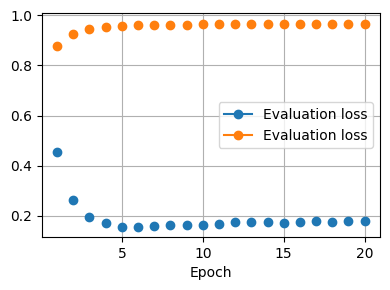

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(trainer.state.log_history)
plt.figure(figsize=(4, 3))
plt.plot(df["epoch"], df["eval_loss"], marker="--o", label="Evaluation loss")
plt.plot(df["epoch"], df["eval_accuracy"], marker="--o", label="Evaluation loss")
# df.plot("epoch", ["eval_loss", "eval_accuracy"], marker="o")
plt.xlabel("Epoch")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
n_examples = [10, 30, 100, 300, 1000]
learning_curves = {
    n: {
        "precision": [],
        "recall": [],
        "f1": [],
        "accuracy": [],
    } for n in n_examples
}
for n in n_examples:
    for _ in range(1):
        model = BertForTokenClassification.from_pretrained(
            "bert-base-uncased",
            num_labels=len(label_list),
            id2label=id2label,
            label2id=label2id
        )
        
        training_args = TrainingArguments(
            output_dir="ner-with-bert",
            overwrite_output_dir=True,
            learning_rate=2e-5,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            num_train_epochs=20,
            weight_decay=0.01,
            eval_strategy="epoch",
            save_strategy="no",
            logging_strategy="epoch",
            # load_best_model_at_end=True,
            # push_to_hub=True,
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_dataset["train"].shuffle().select(range(n)),
            eval_dataset=tokenized_dataset["test"],
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )

        trainer.train()
        df = pd.DataFrame(trainer.state.log_history)
        plt.figure(figsize=(4, 3))
        plt.plot(df["epoch"], df["eval_loss"], marker="o", label="Evaluation loss")
        plt.plot(df["epoch"], df["eval_accuracy"], marker="o", label="Evaluation loss")
        # df.plot("epoch", ["eval_loss", "eval_accuracy"], marker="o")
        plt.xlabel("Epoch")
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

        eval_scores = trainer.evaluate()
        for metric in learning_curves[n]:
            learning_curves[n][metric].append(eval_scores["eval_"+metric])

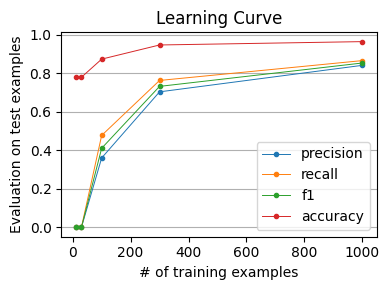

In [94]:
plt.figure(figsize=(4, 3))
for metric in learning_curves[10]:
    x = n_examples
    y = [np.mean(learning_curves[n][metric]) for n in n_examples]
    plt.plot(x, y, "-o", label=metric, markersize=3, linewidth=0.7)
plt.xlabel("# of training examples")
plt.ylabel("Evaluation on test examples")
plt.grid(axis="y")
plt.legend()
plt.title("Learning Curve")
plt.tight_layout()
plt.show()